In [1]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from scipy import signal
from scipy.fftpack import fftfreq
from PIL import Image
import os
from plot_utils import multiplot, doubleplot, doubleplotline, multiplotline, overlaymultiplot
from scipy.signal import blackman
from tifffile import imread
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from Strip2DFFT import doFilterFFT, do2DFFT, do2DInverseFFT, CrossCorrelation, CrossCorrelationStrip, doFilterFFT, do2DFFT, do2DInverseFFT, FFTStrip

In the block below specify the target directory in which the result images would be written. Specify the full path to the Kymograph image for curvature and intensity to compute auto and cross correlation peaks for both. The axes keyword tells the program that it is seeing an X-Y image

In [2]:
targetdir = '/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/'
#For curvature
sourceimageA = '/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/KymographN5Circle.tif'
#For Intensity
sourceimageB = '/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/KymographN5Circle.tif'

SaveFileName = "Curvature-Curvature";

base = os.path.split(sourceimageA)[-1]

Filename = os.path.splitext(base)
axes = 'YX'

In the block below we read the two images using custom made imread function for tifffiles and displaying them

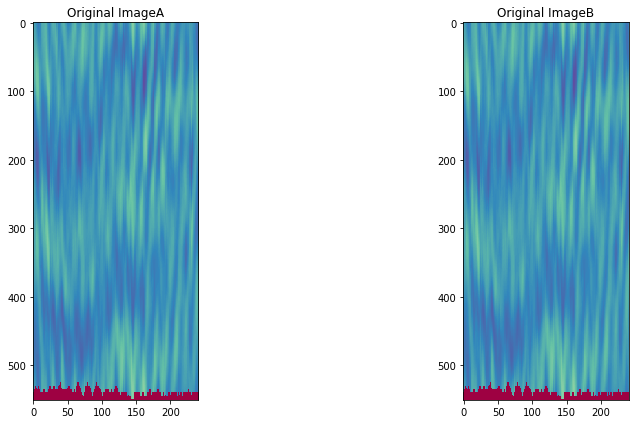

In [3]:
originalimageA = imread(sourceimageA)
originalimageB = imread(sourceimageB)
doubleplot(originalimageA, originalimageB, "Original ImageA", "Original ImageB")

# Fourier Transform of a block of Kymograph

Parameters to be specified:

1) Time_unit = frame to second conversion for the experiment

2) StartSection = Starting of the block at this pixel unit

3) EndSection = Ending of the block at this pixel unit

4) Max Range in hertz for the Fourier transform plot

In [4]:
#Enter time unit in seconds
Time_unit = 5
#Enter pixel to micrometer conversion
Xcalibration = 0.212
#Remove the first zero line if there, else put 0
CutSectionX = 1
#Enter start y pixel unit for the section
StartSection = 0
#Enter end y pixel unit for section
EndSection = 600
#Range of Plot in Hertz
maxXrange = 1

Cut the Kymograph from the start to the endsection value as specified above

In [5]:

imageA = originalimageA[StartSection:EndSection, :]
imageB = originalimageB[StartSection:EndSection, :]

min = 0;
max = 1;
imageA = normalizeMinMax(imageA, min, max)
imageB = normalizeMinMax(imageB, min, max)
Start = StartSection
End = EndSection
block = EndSection - StartSection
axes = 'YX'
allfrequ = 0
onedimg, frequ = doFilterFFT(imageA, Time_unit, False)
allfrequ=onedimg


Show the FFT image along with the original image and save it as a tiff file in the target directory, also save the 1D projection of the twoDFFT as a png file

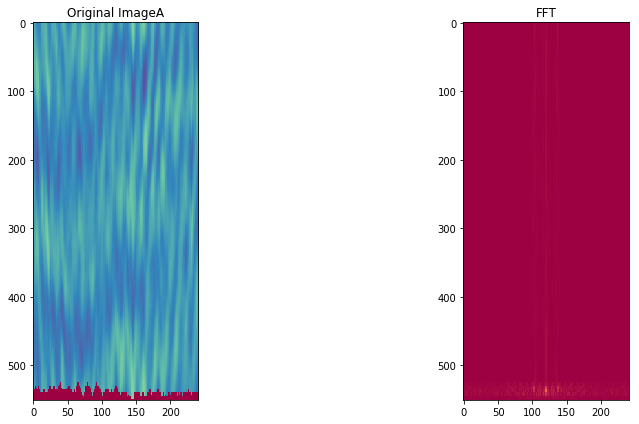

/Users/aimachine/PyImage/utils/Normalize.py:48: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/FFTPlotBokehKymographN5Circle.png'

In [6]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import export_png, output_notebook
TwoDimage = FFTStrip(imageA)
doubleplot(imageA, TwoDimage, "Original ImageA",  "FFT")
save_tiff_imagej_compatible((targetdir + "TwoDFFT" +os.path.basename(Filename[0]) +os.path.basename(Filename[1]) ) , TwoDimage, axes)


p = figure(title='FFT (hertz)', x_axis_label='Frequency', y_axis_label='Amplitude')
p.line(frequ, onedimg, legend = "FFT (hertz)", line_width = 2)
output_notebook()
show(p)
export_png(p, filename=targetdir + 'FFTPlotBokeh' + Filename[0] + '.png')


# Computing Phase of Curvature and Intensity Kymograph and their difference


/Users/aimachine/PyImage/utils/Normalize.py:48: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


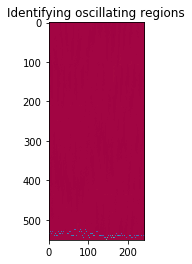

In [7]:
from Strip2DFFT import PhaseDiffStrip
from matplotlib import cm
DifferenceImage = PhaseDiffStrip(imageA)
plt.imshow(DifferenceImage, cmap = cm.Spectral)
plt.title("Identifying oscillating regions")
save_tiff_imagej_compatible((targetdir + "PhaseDiff" +os.path.basename(Filename[0]) +os.path.basename(Filename[1]) ) , DifferenceImage, axes)


# Hough Transform of the Kymograph chosen to compute the wave velocity

In [8]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from scipy import signal
import scipy.fftpack as fftpack
from scipy.fftpack import fftfreq
import matplotlib.pyplot as plt
import os
import math
import cv2 as cv
from skimage import data, color, io, img_as_float
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from skimage.feature import canny
from scipy.signal import blackman
from tifffile import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.fftpack import fft
from plot_utils import multiplot
from matplotlib.colors import LogNorm
from skimage.filters import threshold_mean, sobel
from skimage.filters import threshold_otsu, threshold_local
from skimage import feature
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from HoughLine import show_hough_linetransform


Here we specify the slope threshold parameter, which vetos the slopes found by Hough transform below this value, this is to avoid spurious line detections by Hough Transform. Enter the vcalue in angles above which you do not expect to see a line (0 degree is high slope, 90 degree is zero slope, enter value beetween 0 and 90)

In [9]:
from skimage import data, io

from skimage.filters import roberts, sobel, scharr, prewitt, gaussian

from skimage.morphology import remove_small_objects, binary_erosion
#If you want to change teh start and the end section to only consider highly oscillating regions do so here
#Change the Numeric value of StartSection and EndSection
Start_Sec = StartSection
End_Sec = 150

Starttime = 0
Endtime = originalimageA.shape[1]
Endtime = 150
imageA = originalimageA[Start_Sec:End_Sec, Starttime:Endtime]
imageB = originalimageB[Start_Sec:End_Sec, Starttime:Endtime]

low_slope_threshold = 0
high_slope_threshold = 20
intensity_threshold = 0.5

#Morphological operations on image


binary = gaussian(imageA, 3)
binary = scharr(binary)
thresh = threshold_mean(binary)
binary = binary > thresh
binary = binary_erosion(binary) 

h, theta, d = hough_line(binary)


Now we draw the lines found by Hough Transform and display their values

Estimated Wave Velocity :  0.6893729484387667
Estimated Wave Velocity :  0.9657176771078031
Estimated Wave Velocity :  4.831565398092411
Estimated Wave Velocity :  0.9657176771078082
Estimated Wave Velocity :  4.8315653980925335
Estimated Wave Velocity :  4.831565398092411
Estimated Wave Velocity :  0.19015694148286094


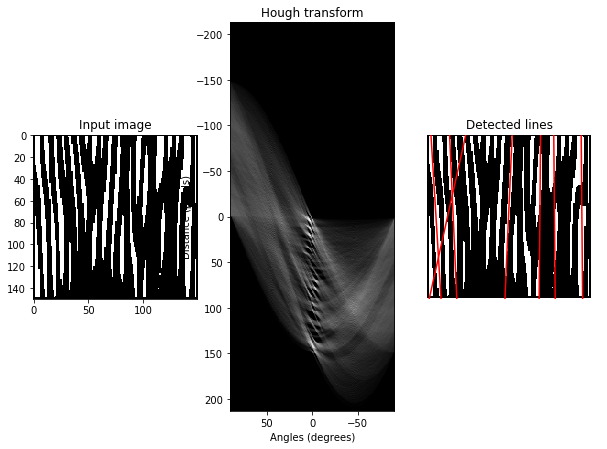

In [10]:


show_hough_linetransform(binary, h, theta, d, Xcalibration, Time_unit,low_slope_threshold,high_slope_threshold,intensity_threshold, targetdir, Filename[0])


# AutoCorrelation and CrossCorrelation between Curvature and Intensity Kymograph

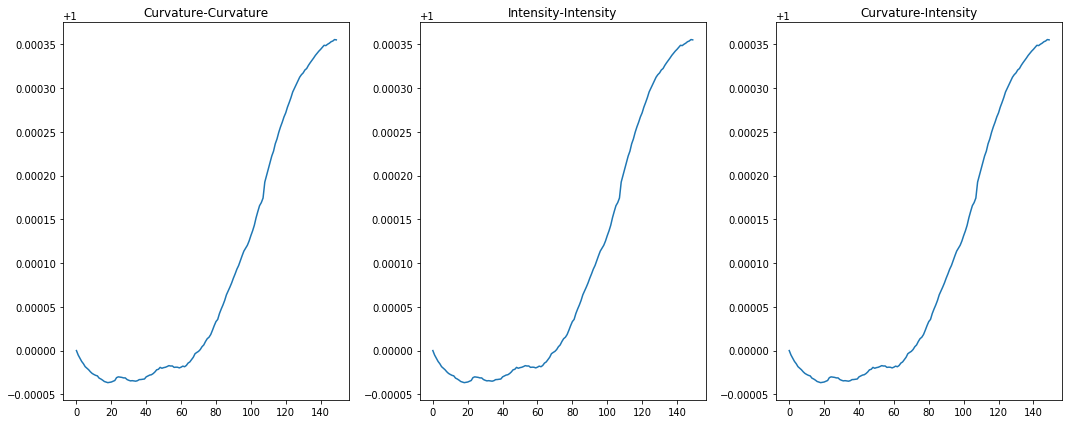

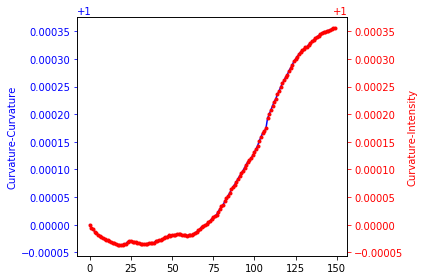

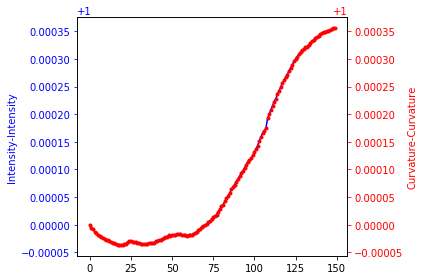

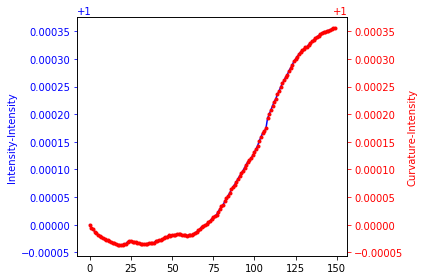

In [11]:
#Curvature and Intensity
crosscorrelation, x = CrossCorrelationStrip(imageA, imageB)
#Curvature and Curvature
autocorrelationCurve, x = CrossCorrelationStrip(imageA, imageA)
#Intensity and Intensity
autocorrelationIntensity, x = CrossCorrelationStrip(imageB, imageB)


crosscorrelation/=crosscorrelation[0]
autocorrelationCurve=autocorrelationCurve/(autocorrelationCurve[0])
autocorrelationIntensity/=autocorrelationIntensity[0]






multiplotline(autocorrelationCurve, autocorrelationIntensity, crosscorrelation, "Curvature-Curvature","Intensity-Intensity", "Curvature-Intensity",targetdir,Filename[0]  )


overlaymultiplot(autocorrelationCurve,crosscorrelation,"Curvature-Curvature", "Curvature-Intensity",targetdir,Filename[0] )
overlaymultiplot(autocorrelationIntensity,autocorrelationCurve,"Intensity-Intensity", "Curvature-Curvature",targetdir,Filename[0] )
overlaymultiplot(autocorrelationIntensity,crosscorrelation,"Intensity-Intensity", "Curvature-Intensity",targetdir,Filename[0] )






In [12]:
#Bokeh plots
p = figure(title='CC and II', x_axis_label='Perimeter', y_axis_label='Amplitude')
p.line(x, autocorrelationCurve, legend = "Cur-Curv", line_width = 2)
p.line(x, autocorrelationIntensity, legend = "Int-Int", line_width = 2, line_color='red')
output_notebook()
show(p)
export_png(p, filename=targetdir + 'CC-II' + Filename[0] + '.png')



Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/CC-IIKymographN5Circle.png'

In [13]:

q = figure(title='CC and CI', x_axis_label='Perimeter', y_axis_label='Amplitude')
q.line(x, autocorrelationCurve, legend = "Cur-Curv", line_width = 2)
q.line(x, crosscorrelation, legend = "Curv-Int", line_width = 2, line_color='red')
output_notebook()
show(q)
export_png(q, filename=targetdir + 'CC-CI' + Filename[0] + '.png')


Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/CC-CIKymographN5Circle.png'

In [14]:

r = figure(title='CI and II', x_axis_label='Perimeter', y_axis_label='Amplitude')
r.line(x, crosscorrelation, legend = "Cur-Int", line_width = 2)
r.line(x, autocorrelationIntensity, legend = "Int-Int", line_width = 2, line_color='red')
output_notebook()
show(r)
export_png(r, filename=targetdir + 'CI-II' + Filename[0] + '.png')

Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/CI-IIKymographN5Circle.png'